In [1]:
from typing import Union, List

import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import functional as F
from IPython.display import clear_output
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np

from nn.module import Linear, SoftmaxActivation, ReLUActivation, SigmoidActivation
from nn.value import Value
from nn.optimizer import AdamOptimizer, RMSPropOptimizer

## Data preparation

In [2]:
class Mnist(Dataset):

    def __init__(self, train=True):
        try:
            self.data = datasets.MNIST(root='./', train=train, download=False, transform=ToTensor())
        except RuntimeError:
            self.data = datasets.MNIST(root='./', train=train, download=True , transform=ToTensor())
            clear_output()

        self.x = self.data.data / 255.
        self.labels = self.data.targets
        self.y = F.one_hot(self.labels, num_classes=10).float()

    def __len__(self): 
        return self.x.shape[0]

    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [3]:
train = Mnist(train=True)

train.x.shape, train.labels.shape, train.y.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]), torch.Size([60000, 10]))

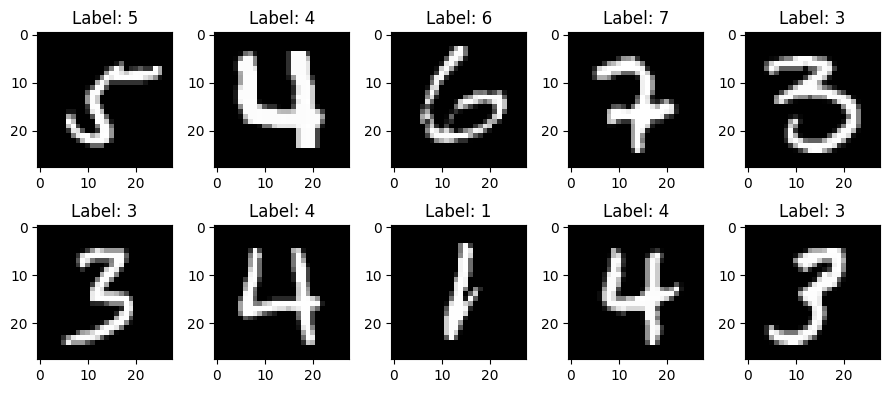

In [4]:
generator = torch.manual_seed(1003)
fig, axes = plt.subplots(2, 5, figsize=(9, 4))
for i, sample in enumerate(torch.randint(len(train), (10, ), generator=generator)):
    ax = axes[i // 5, i % 5]
    ax.imshow(train.x[sample], cmap='gray')
    ax.set_title('Label: {}'.format(train.labels[sample]))
_ = plt.tight_layout()

In [5]:
batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size)

## NN models

### Single layer NN

In [6]:
class SingleLayerNN:
    def __init__(self, num_inputs, num_outputs, activation_class=SoftmaxActivation):
        self._num_inputs = num_inputs
        self._num_outputs = num_outputs
        self._linear_layer = Linear(num_inputs, num_outputs)
        self._activation_layer = activation_class(num_outputs)

    def __call__(self, X: Union[List[List[float]], torch.Tensor]) -> List[List[float]]:
        """Forward pass for multiple samples

        Parameters
        ----------
        X: 2D array (list or torch.Tensor)
            Input samples (each row is a sample)

        Return
        ------
            2D list of floats
        """
        if isinstance(X, torch.Tensor):
            X = X.tolist()
        return [self._single_sample_forward(X[i]) for i in range(len(X))]

    def _single_sample_forward(self, x):
        logits = self._linear_layer(x)
        return self._activation_layer(logits)

    def parameters(self):
        return self._linear_layer.parameters() + self._activation_layer.parameters()

single_layer_nn = SingleLayerNN(28 ** 2, 10, )

### MLP

In [7]:
class MLP:
    def __init__(self):
        self._layers = [Linear(28**2, 16), Linear(16, 16), Linear(16, 10)]
        self._activations = [SigmoidActivation(16), ReLUActivation(16), SoftmaxActivation(10)]

    def __call__(self, X: Union[List[List[float]], torch.Tensor]) -> List[List[float]]:
        """Forward pass for multiple samples

        Parameters
        ----------
        X: 2D array (list or torch.Tensor)
            Input samples (each row is a sample)

        Return
        ------
            2D list of floats
        """
        if isinstance(X, torch.Tensor):
            X = X.tolist()
        return [self._single_sample_forward(X[i]) for i in range(len(X))]

    def _single_sample_forward(self, x):
        for linear_layer, activation_layer in zip(self._layers, self._activations):
            x = linear_layer(x)
            x = activation_layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self._layers:
            params.extend(layer.parameters())
        for activation in self._activations:
            params.extend(activation.parameters())

        return params

### CNN

## Losses

In [8]:
def mse_loss(Y_pred: List[List[Value]], Y: torch.Tensor):
    """
    Parameters
    ----------
    Y_pred: 2D array
        each row is corresponds to a sample
    Y: 2D array
        each row is corresponds to a sample
    """
    if isinstance(Y, torch.Tensor):
        Y = Y.tolist()
    n = len(Y_pred)
    loss = 0
    for y_pred, y in zip(Y_pred, Y):
        loss = loss + sum((y_pred_i - y_i)**2 for y_pred_i, y_i in zip(y_pred, y))
    loss = loss / n
    return loss

def cross_entropy_loss(Y_pred: List[List[Value]], Y: torch.Tensor):
    if isinstance(Y, torch.Tensor):
        Y = Y.tolist()
    n = len(Y_pred)
    loss = 0
    for y_pred, y in zip(Y_pred, Y):
        truth_label_idx = y.index(1)
        loss = loss + y_pred[truth_label_idx].log()
    loss = loss / n
    return -loss


## Training

In [9]:
def train_one_epoch(model, dataloader, L, optimizer):
    train_loss = 0.

    for idx, (X, y) in enumerate(dataloader):
        print("Iteration:", idx)
        X = X.reshape(X.shape[0], -1)

        pred = model(X.tolist())
        loss = L(pred, y)
        print("Loss:", loss.data)
        train_loss += loss.data
        
        optimizer.zero_grad()
        loss.back_prop()
        optimizer.step()

    return train_loss / (idx + 1)

### Training Single Layer Neural Net

In [10]:
adam_optimizer = AdamOptimizer(single_layer_nn.parameters())

train_one_epoch(single_layer_nn, train_dataloader, cross_entropy_loss, adam_optimizer)

Iteration 0
1.529675801585129


/home/bohdan/MFML/NN/nn/nn.py:77: RuntimeWarning: invalid value encountered in log
  local_grad_wrt_exponent = np.log(self.data) * out.data


Iteration 1
1.5847287302371014
Iteration 2
1.5345824705132936
Iteration 3
1.5096761557897787
Iteration 4
1.3934802120384253
Iteration 5
1.3818821953911784
Iteration 6
1.194910672305235
Iteration 7
1.1460065452849164
Iteration 8
1.4331324721770455
Iteration 9
1.16262921792541
Iteration 10
1.2898492314903036
Iteration 11
1.2728454413651618
Iteration 12
1.1011343211753206
Iteration 13
1.2316576714081449
Iteration 14
1.2071401090618517
Iteration 15
1.1783495359323286
Iteration 16
1.1242712298405388
Iteration 17
1.1710726807346903
Iteration 18
1.1886052264266946
Iteration 19
1.2632702889715537
Iteration 20
1.1317978720700035
Iteration 21
1.152304434684629
Iteration 22
1.1683663661316777
Iteration 23
0.9679259629557802
Iteration 24
1.2451207777693243
Iteration 25
1.1285748244840916
Iteration 26
0.9051901123527144
Iteration 27
1.1107427523836553
Iteration 28
0.9799026611666384
Iteration 29
1.0405849928356532
Iteration 30
0.9390968842436375
Iteration 31
1.0681372007620393
Iteration 32
1.038566

### Training MLP

In [10]:
mlp = MLP()
adam_optimizer = AdamOptimizer(mlp.parameters())

train_one_epoch(mlp, train_dataloader, cross_entropy_loss, adam_optimizer)

Iteration 0
5.122727743047129
Iteration 1
4.534508000586788
Iteration 2
4.816223004539893
Iteration 3
4.6220084948440565
Iteration 4
5.124501983426656
Iteration 5
4.877552391370841
Iteration 6
5.355560363345898
Iteration 7
5.204331438855478
Iteration 8
4.506618392331651
Iteration 9
5.161629420985222
Iteration 10
4.060106880227875
Iteration 11
4.835505861542301
Iteration 12
4.967512329552289
Iteration 13
4.0454648186980675
Iteration 14
4.908632351369028
Iteration 15
4.05601383963408
Iteration 16
4.220562858813823
Iteration 17
4.288389494000136
Iteration 18
3.6179272847468433
Iteration 19
3.78506929979376
Iteration 20
4.937564879994476
Iteration 21
4.000968397254889
Iteration 22
3.846823262245305
Iteration 23
4.149397699658529
Iteration 24
3.8241234597940674
Iteration 25
3.721277168833699
Iteration 26


KeyboardInterrupt: 